# Lesson: Hands-on A/B test modeling

Now that we covered the intuition behind Bayesian modeling and sampling, let's roll up our sleeves and get to actual modeling. You remember the A/B test model? Of course you do! How could forget such a poetic model, taught by as seductive a voice as Thomas'?

Well, let's imagine that we actually have to _do_ that analysis, and code up this model ourselves. How do we do that? I'll show you right now.

In this lesson, you will learn about:

1. Installing PyMC

    - Why virtual environments are important
    - Using conda
    - Starting Jupyter Lab

2. Getting the plausible values

    - Importing the data
    - Coding up the A/B test model in PyMC
    - Checking our prior
    - Fitting the model

3. Formatting the samples

    - What is ArviZ?
    - What is `InferenceData`?
    - Why is it useful?
    - What are a model's dimensions and coordinates?

4. Getting analytical
    - Checking convergence
    - Analyzing the results
    - Checking update of beliefs
    - Checking the model's predictions
    - Visualizing the Bayesian workflow

5. Putting it together
    - Writing a new model for A/B test
    - Doing everything in one step
    - See how easy it is to fit it
    - Compare versions A and B
    - Decide on the best version

6. Bonus `InferenceData` Cheatsheet

Let's dive right into it and see how we define a model in PyMC and then perform inference! Are you as excited as I am??

A word of caution: some parts will feel weird and unfamiliar. Don't worry exactly about what all this means just yet. Simply focus on identifying the big parts of the model. You'll have plenty of time to understand the rest throughout this course.

Before anything though, let's install PyMC!

## Installing PyMC

As PyMC is an actively developed package, the best practices for installation can sometimes change, so the best resource to be up-to-date is to take a look at the Wikis online. There is one for each platform: [MacOS](https://github.com/pymc-devs/PyMC/wiki/Installation-Guide-(MacOS)), [Windows](https://github.com/pymc-devs/PyMC/wiki/Installation-Guide-(Windows)) and [Linux](https://github.com/pymc-devs/PyMC/wiki/Installation-Guide-(Linux)).

Let's go to the terminal to install PyMC in a brand new virtual environment on MacOS!

### Section recap

- Prefer conda to install PyMC -- the C compiler infrastructure will be taken care of for you.

## Getting the plausible values

In this section, we'll amp up the ante and _code_ up the A/B test model. In other words, Thomas _told_ you how easy and useful Bayes is -- now I'm gonna _show_ you. I could also add that Bayesian stats are cool, but that would be redundant -- you saw how darn cool we are in the intro video...

Ok, let's import the packages we need:

### Importing the data

What do we need next? The A/B test data of course! Let's load them:

In [1]:
import pandas as pd

signups = pd.read_csv("data/control-signups.csv", index_col=0)

And check out what they look like:

In [2]:
import arviz as az
import matplotlib.pyplot as plt

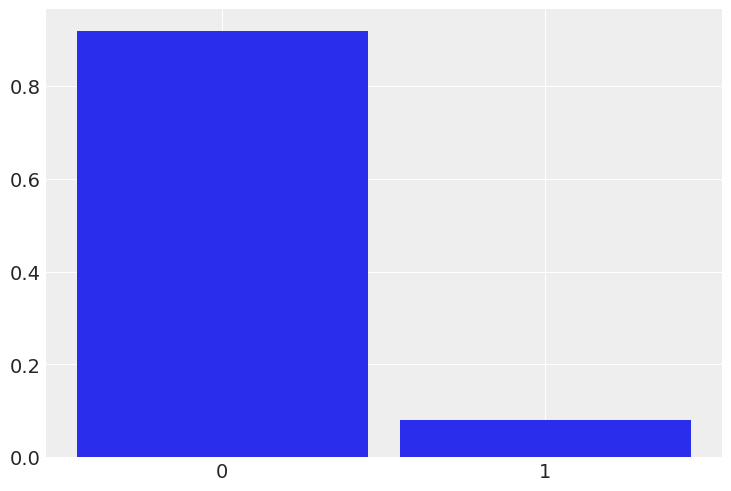

In [3]:
az.style.use("arviz-darkgrid")
az.plot_dist(signups);

Just a note: we're using a library called ArviZ to make that plot. Keep it in mind, you'll use it throughout the course and get a more thorough introduction in the coming lesson. In short, ArviZ is useful for any Bayesian plot and to store and analyze the results of your Bayesian models.

So, what can we make of this graph? Out of 100 people who saw our website, 8 of them clicked on the button (success), while 92 didn't do anything (failure) -- yes, the life of marketers is even harder than that of Dwayne Johnson's bathroom scale.

But, if PyMC can't save that poor scale, it can save marketers! How? By doing all the heavy lifting for them!

### Coding up the PyMC model

Here is the full model:

In [4]:
# LIVE CODE THIS!!!
import pymc as pm

with pm.Model() as model_signups:
    # Parameter = prior solution space
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)

    # Evaluator: likelihood function
    n_signups = pm.Binomial(
        "n_signups", p=conversion_rate, n=len(signups), observed=signups.sum()
    )

Pretty simple, right?

Now is actually time to test yourself:

1. **Did you notice we changed likelihood here?**

In the previous lesson, Thomas used a Bernoulli likelihood, for the sake of simplicity. But this is actually a particular case of the Binomial distribution, that we'll be using now. 

Why? There are several reasons, but the main one is that it matches the generative process more closely: we have 100 (`len(signups)`) binary trials (0s and 1s, i.e did the user sign up or not?), and those trials succeed with the probability `conversion_rate`, that we're trying to infer. It's like tossing a coin 100 times, counting how many times it landed on heads, and inferring whether the coin is fair or not. This describes _exactly_ a process that fits a Binomial distribution.

Are you as lost as when you watched Matrix 4? Well, first of all, my condolences -- I'm sorry that you had to suffer through that movie. Second, don't worry, that's normal. I'm just giving you the high level view. Ravin will dive into more details in the next lesson.

2. **What quantity are we really interested in with this model?**  

`conversion_rate` (the `p` parameter of the Binomial), because it's an estimate of the true conversion rate, i.e what we're really after.

3. **Do you remember what we do in the Bayesian framework when we don't know something?**

As Beyoncé would say: "Just put a prior on it!".

4. **Finally, do you remember why we're using a Beta prior for `conversion_rate`?**

Because it's a... conversion rate, as Captain Obvious would say! And the Beta family is perfect for this, as it spits out values only on the $[0, 1]$ interval. Again, I'm just telling you _why_ we're doing this -- you'll see the details in the coming lessons.

### Checking our assumptions

Now, you may be wondering:
> But Alex, are you sure Beyoncé said that?

Good question. But I hope you're also wondering:

> How did you choose this exact Beta prior? 

You're not?? Well go ahead, ask yourself that. Go ahead, I'm waiting.

Wow, _great_ question! In other words: **which conversion percentages is our model expecting before seeing any data?**

As you'll learn later, this is called a prior predictive check, and it's very simple to do it with PyMC and another library called ArviZ (I'll talk more about it later in this lesson):

In [5]:
with model_signups:
    prior_samples = pm.sample_prior_predictive()

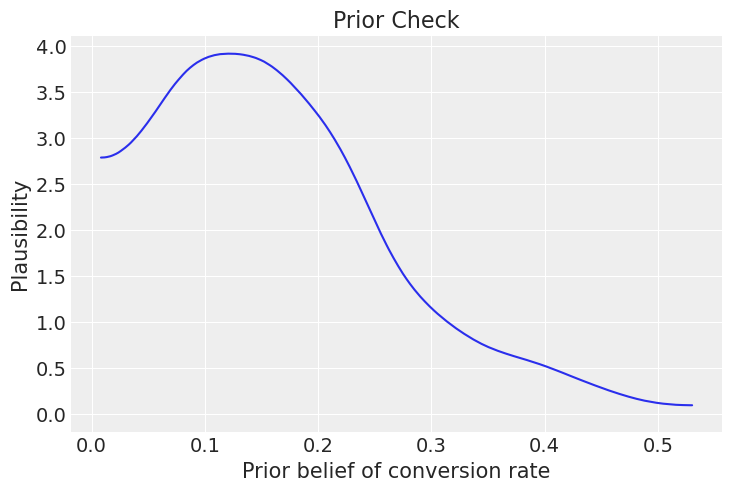

In [6]:
ax = az.plot_dist(prior_samples.prior["conversion_rate"])
ax.set(
    xlabel="Prior belief of conversion rate", ylabel="Plausibility", title="Prior Check"
);

This graph just tells us the percentages: before seeing any data, we expect our conversion rate to be between 0 and 0.6, with most of the probability mass until 0.3. That makes sense, right? Conversion rates are usually low.

But **how many signups does our model expect before seeing any data?** In other words, how does our assumptions about conversion rates translate to actual signups (aka the data space)?** Let's check, with the same kind of plot as above:

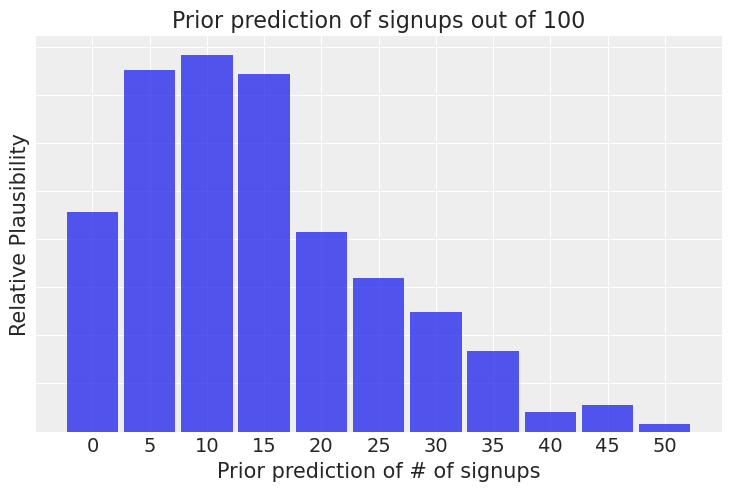

In [7]:
ax = az.plot_dist(
    prior_samples.prior_predictive["n_signups"], hist_kwargs={"alpha": 0.8}
)
ax.set(
    xlabel="Prior prediction of # of signups",
    ylabel="Relative Plausibility",
    title="Prior prediction of signups out of 100",
)
plt.tick_params(left=False, labelleft=False)

This graph tells us the number of successes our model expects before being confronted to the real world. It does fit our domain knowledge: high number of signups are very rare, and a number of signups around 4 to 40 out of 100 trials (remember that the maximum is 100 here, the size of our data) seems reasonable.

What if this graph didn't make sense? Well, we would try another prior (another Beta, or another distribution) for the conversion rate, or even another likelihood (that happens less often, but sometimes your choice of likelihood is ill-advised).

But remember, Peter: with great power comes great responsibility. Oh no wait, that's for a movie I'm shooting soon. Where is the script for the Intuitive Bayes course? Ah, there it is!

So, remember, Peter: **a likelihood is just a prior for the data, and priors are just assumptions, which means you can change them and test them however you want**. We'll saw that throughout the course.

So what do we need to do now? Confront our model to the real world -- I know that's what you wanna do, you little scoundrel!

### Fitting the model to data

Now is the time to let our model see the data, and update our knowledge... if needed!

PyMC's `sample` function does exactly that:

In [8]:
with model_signups:
    # Posterior solution space
    plausible_values = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Sampling worked seamlessly. We didn't get any warning and automatically got our results in the `plausible_values` object (which is an Arviz `InferenceData` object). In the next section, we'll explore our inferences. But first, let's recap!

### Section recap

- We imported the data and saw that we had 100 binary trials.
- Therefore, we used a Binomial distribution for the data, and a Beta distribution for the Binomial's rate of success.
- We checked that our assumptions on the conversion rate (Beta distribution) fitted our domain knowledge.
- We made sure the model didn't expect absurd signup numbers before seeing any data (prior predictive check).
- We confronted our model and assumptions to the real world, by fitting it to the data (`pm.sample`).
- The big object we got from `pm.sample` is called `InferenceData` and handled by ArviZ.

_NB: we went very fast here. For more details and exploration of `InferenceData` magic, refer to the bonus section at the end of this lesson._

## Getting analytical

Now that we have results, we want to know what the true conversion rate is! That's when we can use ArviZ functions, since `pm.sample` returns an `InferenceData` object by default.

### Did the model converge?

In [9]:
az.summary(plausible_values, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
conversion_rate,0.09,0.03,0.04,0.14


The summary is a quick way to glance at parameter estimates. That's normal if you don't understand all the columns for now. We'll see more summaries during the course.

You can also refer to the accompanying video for a short explanation of the some of the columns, as well as to the [ArviZ documentation](https://arviz-devs.github.io/arviz/api/generated/arviz.summary.html).

In practice though, summaries are not what you're gonna use most -- plots are much more useful and intuitive. One of the most common is the trace plot:

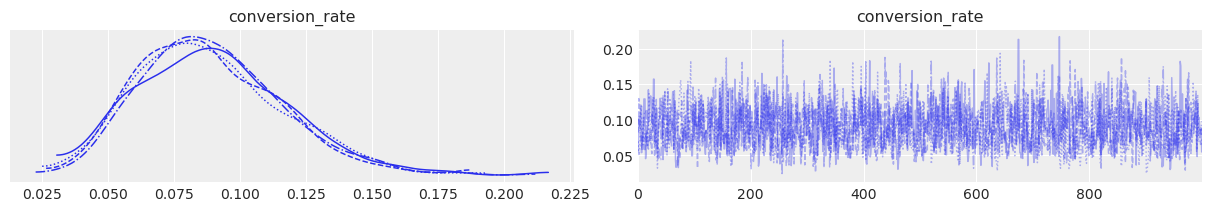

In [10]:
az.plot_trace(plausible_values);

I'll explain how to interpret it in the linear regression lesson. For now, just consider that if the plot on the right (displaying all the iterations made by our sampler) looks like random noise (i.e there are no patterns), this is a very good sign.

### What are our results then??

Now, do you remember what we're after in this model? The conversion rate of the website, `conversion_rate` in our model. So what does the model say after seeing the data?

We have a preview in the plot above, to the left, but that KDE is not very informative. There is a better way to visualize it in Arviz: the `plot_posterior` function! Since I know the true conversion rate (yes, I am _that_ smart, thank you), we'll plot it as a reference line:

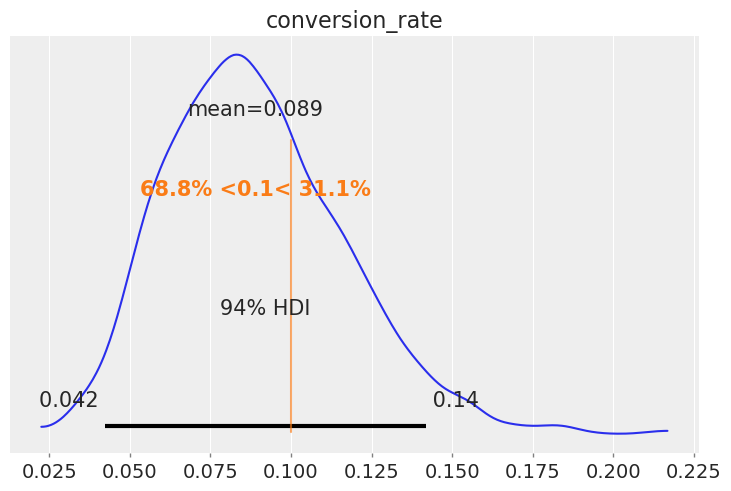

In [11]:
az.plot_posterior(plausible_values, ref_val=0.1);

Wait, wait, I know the face you're making!

![Lost](https://media.giphy.com/media/bqyck3FaMqOzqCrFQc/giphy.gif)

How do I know? That's the face _I_ make when my accountant tells me "this transaction is eligible to the intra-European VAT reverse-charge mechanism".

Rest assured: unlike intra EU accounting, this plot will become way clearer (and cooler) once I explain it.

Basically, the model is telling us that **the conversion rate is between 4% and 14%, with a 9% average and 94% probability**. Why 94%? Well, why not? Yeah, I hate it when people do that too -- come on, it's just a way to dodge the question!

Here though, this answer _truly_ makes sense: you're used to 95% intervals -- but why? There is nothing magical about 95. If anything, [73 is much more magical](https://bigbangtheory.fandom.com/wiki/73)!

Did you get the reference? 

![SheldonWink](https://media.giphy.com/media/13Syr1nwDffUcw/giphy.gif)

The point is, in the Bayesian framework you can focus on any probability you want, because we're just counting the posterior samples respecting the given constraint -- remember Thomas' introductory lesson? It's the same thing.

So, by the same logic, as indicated in the plot, given our data and priors, the model considers that **there is an about 70% chance that the true conversion rate is below 10%, and an about 30% chance that it's above**.

In short: our model was able to recover the true latent conversion rate, although with substantial uncertainty -- we only have 100 samples after all!

### Did we update our beliefs?

Are we wiser than before confronting the model to data though? In other words: did we update our assumptions about possible true conversion rates after observing conversion data?

The `az.plot_dist_comparison` answers exactly that question.

_NB: The `extend` function below is just a nice way to combine several `InferenceData` objects together -- e.g prior predictive, posterior and posterior predictive samples._

In [12]:
with model_signups:
    plausible_values.extend(prior_samples)

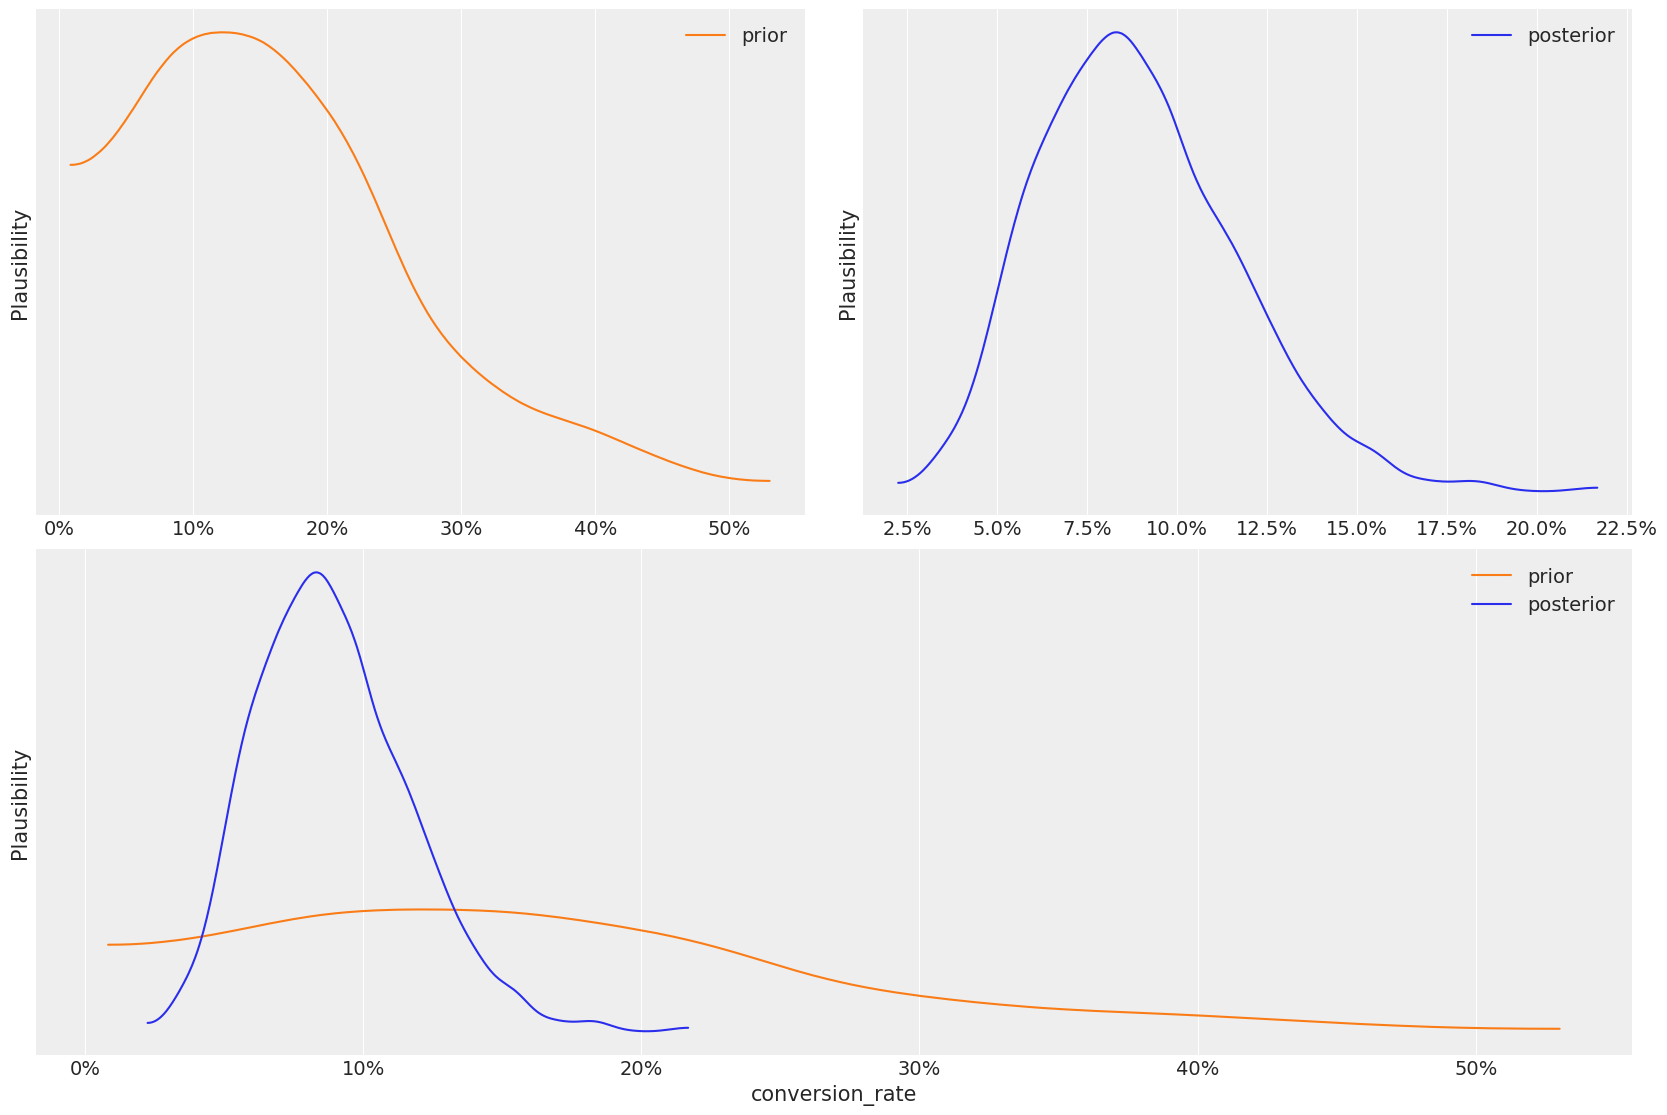

In [13]:
import matplotlib.ticker as mtick

axes = az.plot_dist_comparison(plausible_values)  # that's the line that counts
for ax in axes.ravel():
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel("Plausibility")
plt.setp(axes, yticks=[]);

So yeah, our beliefs about the conversion rate were clearly updated by the data -- they are much more narrow now.

But, same question as when we looked at the prior:

> Alex, are you really sure that Beyoncé said that??

Will you stop with Beyoncé already?! _I_ don't know, _you_ don't know, _we_ will never know -- as Thomas told you, to be good Bayesians, you need to get comfortable with uncertainty!

### Does the model make good predictions?

So, the real question is:

> Is this model any good?

Does updating our beliefs translate into better predictions?

Good news: simulating future possible observations is just one more line of code in PyMC:

In [14]:
with model_signups:
    posterior_predictives = pm.sample_posterior_predictive(plausible_values)
    plausible_values.extend(posterior_predictives)

You may have guessed it: this is called a **posterior predictive check**, and we'll see a lot of them in the course.

For now, let's plot those future _possible_ observations, and overlay the _real_ observations on top of them. As a bonus, I also plotted the prior predictions. That way, you can see how updating our beliefs translates into better predictions.

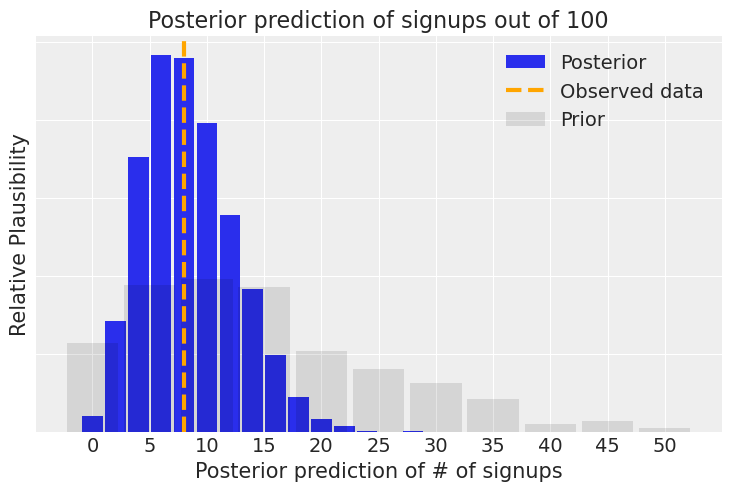

In [15]:
ax = az.plot_dist(
    plausible_values.posterior_predictive["n_signups"],
    label="Posterior",
)
ax.axvline(
    plausible_values.observed_data["n_signups"],
    ls="--",
    lw=3,
    color="orange",
    label="Observed data",
)
az.plot_dist(
    plausible_values.prior_predictive["n_signups"],
    label="Prior",
    color="black",
    hist_kwargs={"alpha": 0.1},
    ax=ax,
)
ax.set(
    xlabel="Posterior prediction of # of signups",
    ylabel="Relative Plausibility",
    title="Posterior prediction of signups out of 100",
)
ax.legend()
plt.tick_params(left=False, labelleft=False)

I'd say that looks very good, doesn't it? The data we observed could have credibly been generated by our model, i.e by the process we're simulating.

Do you still feel as confused as in Matrix 4? Don't worry, that's normal -- we went through a lot of concepts, and that was your first PyMC model! As you get exposed to more of those during the course (and probably rewatch some videos), your understanding will increase. By the way, this is where the comparison with Matrix 4 stops: the more you watch it, the less you understand it.

But don't sell yourself short: as you'll see in details in the Linear Regression lesson, you already went through some parts of what's called the Bayesian workflow. Here it is:

![workflow](img/IB_Bayesian_workflow.jpg)

We'll detail all these steps when we talk about linear regression, but this is going to be a handy reference throughout the course so keep it in mind. Actually, let's recap, following the workflow steps.

### Section recap

In this section, we:
- Gathered data and prior knowledge
- Created our model to infer the conversion rate
- Stated and checked our assumptions before seeing the data (`pm.sample_prior_predictive`)
- Confronted our model to reality (`pm.sample`)
- Estimated the conversion rate with PyMC
- Double checked that we can trust the results (summary, trace plot...)
- Simulated the future to evaluate our model's predictions (`pm.sample_posterior_predictive`)
- Saw that the Bayesian workflow is super critical

## Putting it together -- the A/B test

Until now, we've only looked at one website. But in real life, we're often interested in comparing two versions of a website and choosing the most efficient one. That's usually called an A/B test.

Let's imagine that the model we've fitted so far is for the **control** version of the website (A), i.e the version all users currently see. Therefore, to run our A/B test, we need a model for the **intervention** (B), where, for instance, we changed the color of the signup button.

Let's load the data, and then what we need to do is just copy our previous model and change a few variable names:

In [16]:
signups_intervention = pd.read_csv("data/intervention-signups.csv", index_col=0)

In [17]:
with pm.Model() as model_signups_intervention:
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)

    n_signups_intervention = pm.Binomial(
        "n_signups_intervention",
        p=conversion_rate,
        n=len(signups_intervention),
        observed=signups_intervention.sum(),
    )

    plausible_values_intervention = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


We got out inference data output. How efficient is our B version inferred to be? Let's ask ArviZ:

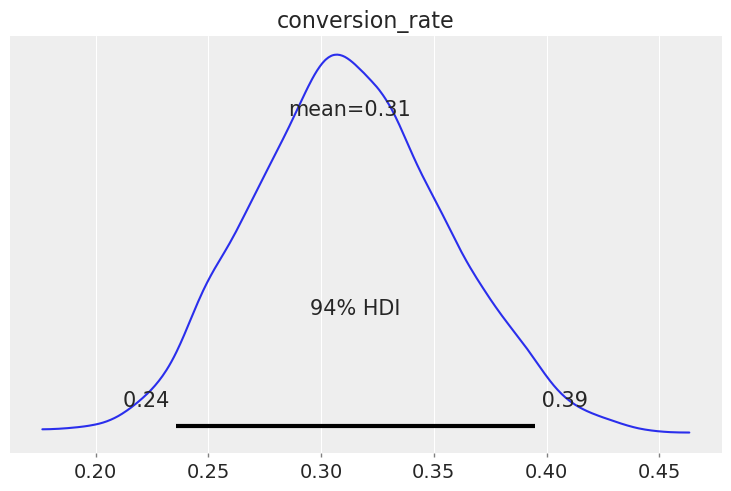

In [18]:
az.plot_posterior(plausible_values_intervention);

Well this version of the website seems to convert much more! We can see that with both the mean and the distribution. Actually, let's plot the conversion of the version side by side. ArviZ has another useful plot:

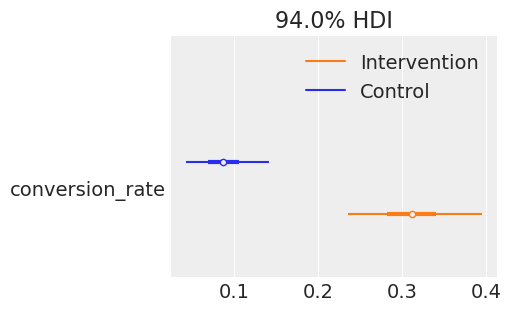

In [19]:
az.plot_forest(
    [plausible_values, plausible_values_intervention],
    model_names=["Control", "Intervention"],
    combined=True,
    figsize=(5, 3),
);

Now we can definitely tell variant B is better!

The conclusion is unambiguous here, but what if the difference was smaller and we wanted to compute the probability than B is better than A? Simple, we just count the cases when B's conversion rate is higher than A's!

In [20]:
diff = (
    plausible_values_intervention.posterior["conversion_rate"]
    - plausible_values.posterior["conversion_rate"]
)

Here, the probability will be equal to one, as we can already see in the forest plot, but we can still plot the distribution of differences with ArviZ, and 0 as a reference line:

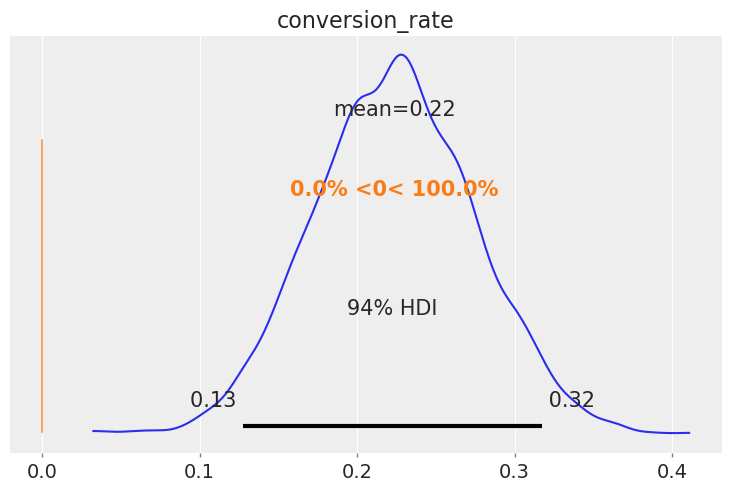

In [21]:
az.plot_posterior(diff, ref_val=0);

As expected, there is no doubt that our intervention is better than the control -- we should probably switch to that version, don't you think?

### Section recap

In this section, we:
- Coded up a new conversion rate model all in one step
- Fit this model to data
- Intuited that this version was more efficient
- Checked that intuition with visual and mathematical comparisons
- Confirmed once again that statistics is just counting

## Lesson recap

- PyMC helps you:
    - focus on model building and improvement 
    - without specialized knowledge about fitting algorithms
- Coding and fitting a model in PyMC is straighforward.
- ArviZ is your friend for all pre- and post-processing modeling steps.
- ArviZ plays well with PyMC.
- `InferenceData` objects are ArviZ's main structure.
- They contain contain everything you need to check, save and reproduce your Bayesian analysis.
- Bayesian analysis is done with multiple packages and PPLs. 
- In this course, we mainly use PyMC, [ArviZ](https://arviz-devs.github.io/arviz/), [NumPy](https://numpy.org/), [Scipy](https://scipy.org/), [Pandas](https://pandas.pydata.org/) and [Xarray](http://xarray.pydata.org/en/stable/).

## Bonus section (unrecorded): `InferenceData` Cheatsheet

In this lesson, we introduced a fundamental new object, the `InferenceData`. It stores everything and lets you reproduce and share your analysis with your best friends at the bar -- what, you don't talk about Bayes when you go partying??

Concretely, `InferenceData` objects contain several groups, each of which is a multidimensional-labeled array with one or more data variables, as shown in the figure below:

![InferenceDataStructure](img/InferenceDataStructure.png)

The full schema specification can be found in [ArviZ's documentation](https://arviz-devs.github.io/arviz/schema/schema.html) and is useful to parse through. 

These groups contain data related to a specific collection such as _posterior_, _observed data_, or _sampler stats_ (sampler quantities like divergence, tree depth, and log likelihood). 

Don't worry about those technical terms for now, we'll teach you that in the "MCMC for practitioners" lesson. We just mention them here to give you a first exposure.

The two most important concepts you have to bear in mind when using `InferenceData` objects are _dimensions_ and _coordinates_.

The **dimensions** of an object are its named axes. A variable containing 1D data will have dimensions `[chain, draw, dim0]`. Indeed the `chain` and `draw` dimensions are always there (this is the result of a fitted Bayesian model, remember?). And then the variables' dimensions are appended. Every dimension present in an `InferenceData` variable must share names with a coordinate.

A **coordinate** is a named array that labels a dimension. For instance, a coordinate that will always be there will be... you guessed it, `chain`, whose values will be `[0, 1, 2, 3]` if you ran 4 chains. And this coordinate labels the `chain` dimension we saw above. In other words, coordinate names and values can be loosely thought of as labels and their corresponding tick labels along a dimension.

We know this sounds dry, as any new concept. Just let it think sink in; you will get it, with time and repeated exposure. 

Actually, a way to jumpstart your understanding of the wonderfulness of `InferenceData` is just to play around with it. In the following cells, you will find a sample of the most useful functions to operate with `InferenceData` objects. 

**This section is not accompanied by a video because it is not mandatory to understand this lesson**. But if you're curious, we encourage you to play around with the code below. You can also use it as a cheatsheet to reuse in your own analysis. This will surely accelerate your understanding of future lessons, and improve your own code.

Happy exploring!

In [22]:
plausible_values

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> prior
	> prior_predictive
	> posterior_predictive

In [23]:
# access a group
plausible_values.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    conversion_rate  (chain, draw) float64 0.06504 0.05366 ... 0.07846 0.08809
Attributes:
    created_at:                 2022-04-18T08:18:21.185353
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2
    sampling_time:              15.30450177192688
    tuning_steps:               1000

In [24]:
# combine chains and draws
plausible_values.posterior.stack(sample=("chain", "draw"))

<xarray.Dataset>
Dimensions:          (sample: 4000)
Coordinates:
  * sample           (sample) MultiIndex
  - chain            (sample) int64 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw             (sample) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    conversion_rate  (sample) float64 0.06504 0.05366 ... 0.07846 0.08809
Attributes:
    created_at:                 2022-04-18T08:18:21.185353
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2
    sampling_time:              15.30450177192688
    tuning_steps:               1000

In [25]:
# obtain a numpy array for a given parameter:
plausible_values.posterior["conversion_rate"].data

array([[0.06504403, 0.05366025, 0.09846847, ..., 0.08892392, 0.08892392,
        0.0549786 ],
       [0.05062392, 0.07124705, 0.05685866, ..., 0.08787996, 0.08017564,
        0.09805696],
       [0.08307456, 0.08307456, 0.12987377, ..., 0.06567124, 0.06567124,
        0.0725299 ],
       [0.10160418, 0.10048384, 0.10048384, ..., 0.0846941 , 0.07846357,
        0.08809039]])

In [26]:
# mean along all dimensions
plausible_values.posterior.mean()

<xarray.Dataset>
Dimensions:          ()
Data variables:
    conversion_rate  float64 0.08897

In [27]:
# specify along which dimension
plausible_values.posterior.mean("draw")

<xarray.Dataset>
Dimensions:          (chain: 4)
Coordinates:
  * chain            (chain) int64 0 1 2 3
Data variables:
    conversion_rate  (chain) float64 0.09008 0.08843 0.08751 0.08987

In [28]:
# any summary function
plausible_values.posterior.quantile(q=[0.25, 0.5, 0.75], dim=("chain", "draw"))

<xarray.Dataset>
Dimensions:          (quantile: 3)
Coordinates:
  * quantile         (quantile) float64 0.25 0.5 0.75
Data variables:
    conversion_rate  (quantile) float64 0.06905 0.08629 0.1063

For more details, you can take a look at the [getting started guide](https://arviz-devs.github.io/arviz/getting_started/index.html) on ArviZ website.

### Section recap

- `pm.sample` returns an `InferenceData` object.
- ArviZ uses it to tidy up and organize the results.
- We use ArviZ to:
    - criticize and compare models
    - plot the results
- The HTML repr is very useful for debugging.
- All groups can be accessed programatically.
- You can use any summary function and specify on which dimension/coordinate.